In [44]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

import rvt.vis
import rvt.blend
import rvt.default

CWD = os.getcwd()

FILENAME = "RIB_enhanced_fnands_openai_optimised_04"
input_dem_path = os.path.join(
    CWD,
    "data",
    "processed",
    "dtm",
    "enhanced",
    FILENAME + ".tif"
)
output_vat_path = os.path.join(
    CWD,
    "data",
    "processed",
    "vat",
    "enhanced",
    FILENAME + ".tif"
)

general_opacity = 50
vat_combination_json_path = "/Users/jamesbyers/code/github/Kaggle/openai_to_z/scratch/RVT/settings/blender_VAT.json"
terrains_sett_json_path = ("/Users/jamesbyers/code/github/Kaggle/openai_to_z/scratch/RVT/settings/default_terrains_settings.json")
nr_processes = 2
save_float = True
save_8bit = True
save_VAT_general = True
save_VAT_flat = True

In [45]:
def compute_combined_vat(input_dem_path, output_vat_path, general_opacity, 
                         vat_comb_json, terrain_sett_json, normalize=False):
    """Compute and save VAT Combined float for a single DTM."""
    if os.path.isfile(output_vat_path):
        print(f"{output_vat_path} already exists. Skipping computation.")
        return output_vat_path

    default_1 = rvt.default.DefaultValues()
    default_2 = rvt.default.DefaultValues()
    default_1.fill_no_data = 0
    default_2.fill_no_data = 0
    default_1.keep_original_no_data = 0
    default_2.keep_original_no_data = 0

    vat_comb_1 = rvt.blend.BlenderCombination()
    vat_comb_2 = rvt.blend.BlenderCombination()
    vat_comb_1.read_from_file(vat_comb_json)
    vat_comb_2.read_from_file(vat_comb_json)
    
    terrain_settings = rvt.blend.TerrainsSettings()
    terrain_settings.read_from_file(terrain_sett_json)
    terrain_1 = terrain_settings.select_terrain_settings_by_name("general")
    terrain_2 = terrain_settings.select_terrain_settings_by_name("flat")
    terrain_1.apply_terrain(default=default_1, combination=vat_comb_1)
    terrain_2.apply_terrain(default=default_2, combination=vat_comb_2)
    
    #####
    dict_arr_res_nd = rvt.default.get_raster_arr(raster_path=input_dem_path)

    if normalize:
        # Prepare normalized DTM
        dtm = dict_arr_res_nd["array"].astype(float)
        finite = dtm[np.isfinite(dtm)]
        lower, upper = np.percentile(finite, [2, 98])
        dtm = np.clip(dtm, lower, upper)
        dtm = (dtm - lower) / (upper - lower)
        # preserve nodata
        if "no_data" in dict_arr_res_nd and dict_arr_res_nd["no_data"] is not None:
            dtm[dict_arr_res_nd["array"] == dict_arr_res_nd["no_data"]] = np.nan
        dem_to_use = dtm
        print(f"Applied percentile normalization ({lower:.2f} - {upper:.2f}) to DTM: {input_dem_path}")
    else:
        # Use the raw DTM array
        dem_to_use = dict_arr_res_nd["array"]

    vat_comb_1.add_dem_arr(dem_arr=dem_to_use, dem_resolution=dict_arr_res_nd["resolution"][0])
    vat_arr_1 = vat_comb_1.render_all_images(default=default_1, no_data=dict_arr_res_nd["no_data"])
    vat_comb_2.add_dem_arr(dem_arr=dem_to_use, dem_resolution=dict_arr_res_nd["resolution"][0])
    vat_arr_2 = vat_comb_2.render_all_images(default=default_2, no_data=dict_arr_res_nd["no_data"])
    #####

    combination = rvt.blend.BlenderCombination()
    combination.create_layer(
        vis_method="VAT general", image=vat_arr_1, normalization="Value",
        minimum=0, maximum=1, blend_mode="Normal", opacity=general_opacity
    )
    combination.create_layer(
        vis_method="VAT flat", image=vat_arr_2, normalization="Value",
        minimum=0, maximum=1, blend_mode="Normal", opacity=100
    )

    os.makedirs(os.path.dirname(output_vat_path), exist_ok=True)
    
    combination.add_dem_path(dem_path=input_dem_path)
    combination.render_all_images(
        save_render_path=output_vat_path, save_visualizations=False, 
        save_float=True, save_8bit=False,
        no_data=dict_arr_res_nd["no_data"]
    )
    print(f"VAT Combined saved to {output_vat_path}")
    return output_vat_path

In [46]:
compute_combined_vat(
        input_dem_path,
        output_vat_path,
        general_opacity,
        vat_combination_json_path,
        terrains_sett_json_path,
        normalize=False
)

VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/enhanced/RIB_enhanced_fnands_openai_optimised_04.tif


'/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/enhanced/RIB_enhanced_fnands_openai_optimised_04.tif'

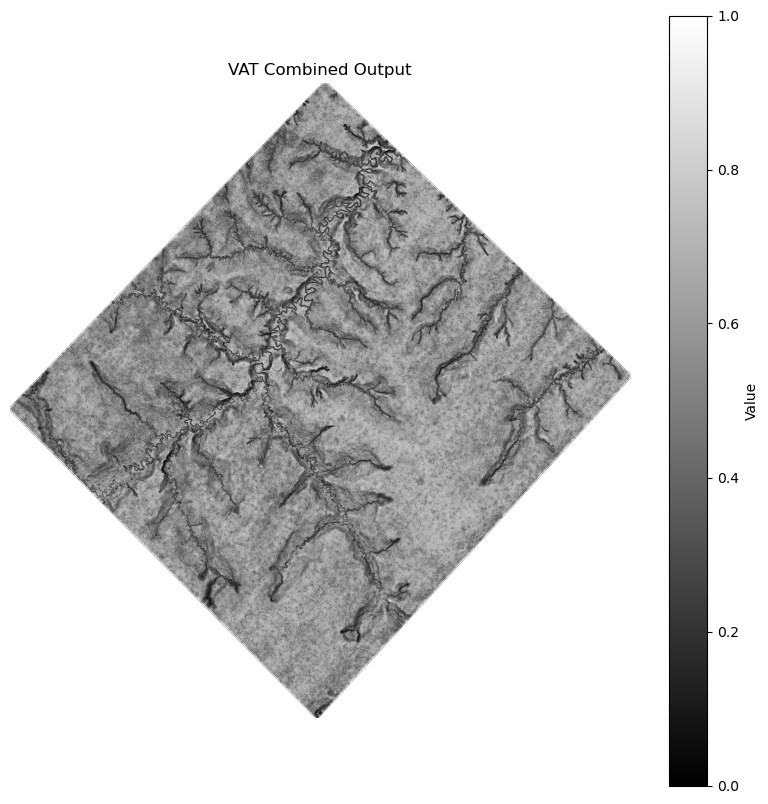

In [54]:
# Open the rendered raster (update with your actual output path if needed)
with rasterio.open(output_vat_path) as src:
    img = src.read(1)  # Read the first band
    # Mask nodata (optional, for better display)
    if src.nodata is not None:
        img = np.ma.masked_equal(img, src.nodata)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.title('VAT Combined Output')
plt.colorbar(label='Value')
plt.axis('off')
plt.show()